## Project : 하위권에 있는 ETF 찾아 수익률 향상시키기

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from pykrx import stock

#### ETF 종목 가져오기
- 목표 : 최하위 ETF 종목 선택하기

In [28]:
# 날짜 설정 
start_date = '20220101'
end_date = '20241231'

In [32]:
# ETF 데이터 가져오기 함수
def fetch_etf_data(etf_ticker):
    try:
        data = stock.get_etf_ohlcv_by_date(start_date, end_date, etf_ticker)
        if not data.empty and "종가" in data.columns:
            return etf_ticker, data["종가"]
        return etf_ticker, None
    except Exception as e:
        print(f"Error fetching {etf_ticker}: {e}")
        return etf_ticker, None

# 포트폴리오 데이터 확인 함수
def check_portfolio_data(etf_ticker, date="20241010"):
    try:
        portfolio = stock.get_etf_portfolio_deposit_file(etf_ticker, date)
        if not portfolio.empty and "비중" in portfolio.columns and portfolio["비중"].sum() > 0:
            valid_stocks = portfolio[portfolio.index.str.match(r"^\d{6}$") & (portfolio["비중"] > 0)]
            if not valid_stocks.empty:
                return etf_ticker, True, valid_stocks
        return etf_ticker, False, None
    except Exception as e:
        print(f"Error checking portfolio for {etf_ticker}: {e}")
        return etf_ticker, False, None

if __name__ == "__main__":
    # 모든 ETF 티커 가져오기
    etf_list = stock.get_etf_ticker_list()

    # 종가 데이터 가져오기
    with mp.Pool(processes=12) as pool:
        results = pool.map(fetch_etf_data, etf_list)

    # 유효한 데이터만 필터링
    etf_prices = {ticker: data for ticker, data in results if isinstance(data, pd.Series) and not data.empty}
    df_etf = pd.DataFrame(etf_prices)

    # 평균 종가 기준 최하위 10개 ETF 찾기
    etf_avg_prices = df_etf.mean()
    lowest_etfs = etf_avg_prices.nsmallest(10)
    print("최하위 10개 ETF (평균 종가 기준):")
    for ticker in lowest_etfs.index:
        name = stock.get_etf_ticker_name(ticker)
        print(f"{ticker}: {name} - 평균 종가: {lowest_etfs[ticker]:.2f}")

    # 포트폴리오 데이터 체크
    print("\n포트폴리오 데이터가 유효한 ETF 확인:")
    with mp.Pool(processes=12) as pool:
        portfolio_results = pool.starmap(check_portfolio_data, [(ticker, "20241010") for ticker in lowest_etfs.index])

    # 결과 분석
    valid_etfs = [(ticker, portfolio) for ticker, valid, portfolio in portfolio_results if valid]
    if not valid_etfs:
        print("최하위 10개 ETF 중 유효한 비중 데이터를 제공하는 ETF가 없습니다.")
    else:
        print("유효한 비중 데이터를 제공하는 최하위 ETF:")
        for ticker, portfolio in valid_etfs:
            name = stock.get_etf_ticker_name(ticker)
            print(f"\n{ticker}: {name}")
            # 컬럼 확인 후 출력
            available_columns = [col for col in ["종목명", "비중"] if col in portfolio.columns]
            if not available_columns:
                print("출력할 유효한 컬럼이 없습니다.")
            else:
                print(portfolio[available_columns].head())

최하위 10개 ETF (평균 종가 기준):
204450: KODEX 차이나H레버리지(H) - 평균 종가: 2118.39
228790: TIGER 화장품 - 평균 종가: 2501.76
252420: RISE 200선물인버스2X - 평균 종가: 2597.76
252670: KODEX 200선물인버스2X - 평균 종가: 2604.34
253230: KIWOOM 200선물인버스2X - 평균 종가: 2606.46
252710: TIGER 200선물인버스2X - 평균 종가: 2743.28
139220: TIGER 200 건설 - 평균 종가: 2970.18
412560: TIGER BBIG레버리지 - 평균 종가: 3135.63
217770: TIGER 원유선물인버스(H) - 평균 종가: 3148.64
117700: KODEX 건설 - 평균 종가: 3182.97

포트폴리오 데이터가 유효한 ETF 확인:
유효한 비중 데이터를 제공하는 최하위 ETF:

228790: TIGER 화장품
           비중
티커           
214450  11.37
051900  10.77
257720   9.98
161890   9.97
278470   9.70

139220: TIGER 200 건설
               비중
티커               
000720  19.200001
028050  19.020000
028260  18.160000
052690  12.920000
006360  12.290000

117700: KODEX 건설
           비중
티커           
028050  18.51
000720  16.99
052690   9.42
006360   8.95
294870   6.34


- 가장 낮은 204450: KODEX 차이나H레버리지(H) ETF를 선택하지 않은 이유

- 1. 실질적으로 데이터를 가져와 보니 비중과 금액이 모두 0으로 표기 되었고 내부에 종목이 너무 많아서 이상하다 생각함
- 2. 한국거래소에서 확인해보니 비중에 대한 정보는 없었음 
- 3. 토스증권에 들어가 종목정보를 확인해보니 비중이 있었음
- 4. 분명 pykrx에서 정보가 제공되었기에 토스증권에 종목별 비중이 있을 것이라 생각되었지만 둘 간의 차이가 있었음
- 5. 둘 간의 차이를 확인해보니 토스증권은 자체적으로 ETF운용사(예: 삼성자산운용)나 다른 데이터 제공업체(예: Bloomberg, Refintiv)에서 정보를 가져와 가공했을 가능성이 크다 판단
- 6. 또한 내부에 종목이 너무 많아 일부를 찾아보니 100000, HN0005 등은 실제 주식 종목 코드가 아니라 선물/스왑 계약을 의미할 가능성이 높아보임
- 7. 204450은 레버리지 ETF 로 주식비중보다 선물/스왑 비중이 클가능성이 높고 일반 주식 ETF에 비해 비중이 명확히 드러나지 않음
- 8. 결론 데이터의 출처가 불분명한 ETF 임으로 개선을 한다는 것은 큰 의미가 없다 판단 최하위권 ETF 중 데이터가 존재하는 종목 선택


#### Monte Carlo 사용

유효한 종목 수: 20

228790 TIGER 화장품 - 최적 비중:
214450: 0.1008 (10.08%)
051900: 0.1218 (12.18%)
257720: 0.1181 (11.81%)
161890: 0.0297 (2.97%)
278470: 0.0107 (1.07%)
090430: 0.0053 (0.53%)
192820: 0.0395 (3.95%)
018290: 0.1242 (12.42%)
002790: 0.0004 (0.04%)
241710: 0.0792 (7.92%)
352480: 0.0093 (0.93%)
114840: 0.0017 (0.17%)
200130: 0.0697 (6.97%)
237880: 0.0498 (4.98%)
251970: 0.1367 (13.67%)
950140: 0.0091 (0.91%)
439090: 0.0034 (0.34%)
024720: 0.0268 (2.68%)
214420: 0.0607 (6.07%)
226320: 0.0031 (0.31%)

최적 포트폴리오 성과:
연율화 수익률: 0.7362
연율화 변동성: 0.4130
샤프 비율: 1.7340

초기 포트폴리오 성과:
연율화 수익률: 0.5484
연율화 변동성: 0.3892
샤프 비율: 1.3577


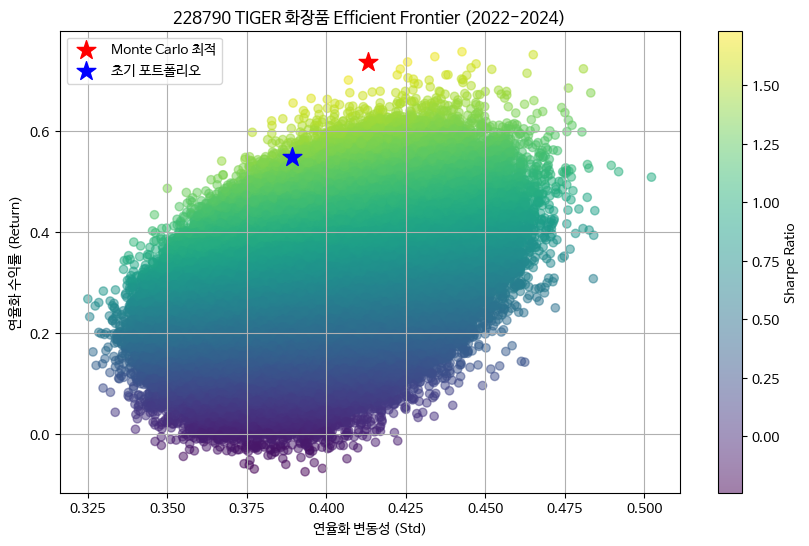

In [43]:
import matplotlib.pyplot as plt

# 설정
etf_ticker = "228790"  # TIGER 화장품
risk_free_rate = 0.02  # 무위험 수익률
date = "20241010"  # 포트폴리오 데이터 기준 날짜

# 1. ETF 구성 종목과 비중 가져오기
portfolio = stock.get_etf_portfolio_deposit_file(etf_ticker, date)
valid_portfolio = portfolio[portfolio.index.str.match(r"^\d{6}$") & (portfolio["비중"] > 0)].copy()
initial_tickers = valid_portfolio.index.tolist()  # 초기 종목 코드
initial_weights = valid_portfolio["비중"].values / 100  # 초기 비중 (소수로 변환)

# 2. 구성 종목의 종가 데이터 가져오기
price_data = {}
for ticker in initial_tickers:
    try:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
        if not df.empty and "종가" in df.columns:
            price_data[ticker] = df["종가"]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# 데이터프레임 결합
prices = pd.DataFrame(price_data)
# 결측값 제거 후 유효한 종목만 추출
prices = prices.dropna()
tickers = prices.columns.tolist()  # 유효한 종목만 사용
print(f"유효한 종목 수: {len(tickers)}")  # 디버깅용

# 초기 비중을 유효한 종목에 맞춰 조정
valid_indices = [initial_tickers.index(ticker) for ticker in tickers if ticker in initial_tickers]
initial_weights = initial_weights[valid_indices]
initial_weights /= initial_weights.sum()  # 비중 합이 1이 되도록 재조정

# 3. 일별 수익률 계산
returns = prices.pct_change().dropna()

# 4. 포트폴리오 성과 계산 함수
def portfolio_performance(weights, returns, risk_free_rate):
    portfolio_returns = returns.dot(weights)
    mean_return = portfolio_returns.mean() * 252  # 연율화 수익률
    portfolio_std = portfolio_returns.std() * np.sqrt(252)  # 연율화 변동성
    sharpe_ratio = (mean_return - risk_free_rate) / portfolio_std
    return mean_return, portfolio_std, sharpe_ratio

# 5. Monte Carlo 시뮬레이션
num_portfolios = 1000000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= weights.sum()
    weights_record.append(weights)
    mean_return, std, sharpe = portfolio_performance(weights, returns, risk_free_rate)
    results[0, i] = mean_return
    results[1, i] = std
    results[2, i] = sharpe

# 6. 최적 포트폴리오 찾기
max_sharpe_idx = results[2].argmax()
optimal_weights = weights_record[max_sharpe_idx]
optimal_return, optimal_std, optimal_sharpe = results[:, max_sharpe_idx]

# 초기 포트폴리오 성과
initial_return, initial_std, initial_sharpe = portfolio_performance(initial_weights, returns, risk_free_rate)

# 7. 결과 출력
print(f"\n{etf_ticker} TIGER 화장품 - 최적 비중:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")

print(f"\n최적 포트폴리오 성과:")
print(f"연율화 수익률: {optimal_return:.4f}")
print(f"연율화 변동성: {optimal_std:.4f}")
print(f"샤프 비율: {optimal_sharpe:.4f}")

print(f"\n초기 포트폴리오 성과:")
print(f"연율화 수익률: {initial_return:.4f}")
print(f"연율화 변동성: {initial_std:.4f}")
print(f"샤프 비율: {initial_sharpe:.4f}")

# 8. Efficient Frontier 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="viridis", marker="o", alpha=0.5)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(optimal_std, optimal_return, marker="*", color="r", s=200, label="Monte Carlo 최적")
plt.scatter(initial_std, initial_return, marker="*", color="b", s=200, label="초기 포트폴리오")
plt.title(f"{etf_ticker} TIGER 화장품 Efficient Frontier (2022-2024)")
plt.xlabel("연율화 변동성 (Std)")
plt.ylabel("연율화 수익률 (Return)")
plt.legend()
plt.grid(True)
plt.show()

#### MVO 사용


228790 TIGER 화장품 - MVO 최적 비중:
214450: 0.3000 (30.00%)
051900: 0.0000 (0.00%)
257720: 0.3000 (30.00%)
161890: 0.0000 (0.00%)
278470: 0.0000 (0.00%)
090430: 0.0000 (0.00%)
192820: 0.0000 (0.00%)
018290: 0.1533 (15.33%)
002790: 0.0000 (0.00%)
241710: 0.0000 (0.00%)
352480: 0.0000 (0.00%)
114840: 0.0000 (0.00%)
200130: 0.0000 (0.00%)
237880: 0.0000 (0.00%)
251970: 0.2467 (24.67%)
950140: 0.0000 (0.00%)
439090: 0.0000 (0.00%)
024720: 0.0000 (0.00%)
214420: 0.0000 (0.00%)
226320: 0.0000 (0.00%)
MVO 연율화 수익률: 1.4635, 변동성: 0.5408, 샤프: 2.6691, 95% VaR: -10.8835

초기 포트폴리오 성과:
연율화 수익률: 0.5484, 변동성: 0.3892, 샤프: 1.3577, 95% VaR: -8.7306


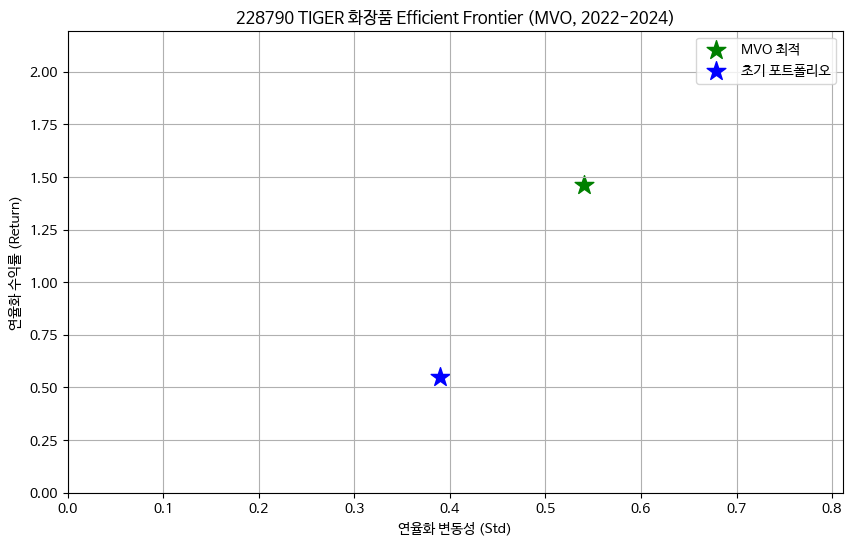

In [44]:
# 설정
etf_ticker = "228790"  # TIGER 화장품
risk_free_rate = 0.02  # 무위험 수익률
date = "20241010"  # 포트폴리오 데이터 기준 날짜

# 1. ETF 구성 종목과 비중 가져오기
portfolio = stock.get_etf_portfolio_deposit_file(etf_ticker, date)
valid_portfolio = portfolio[portfolio.index.str.match(r"^\d{6}$") & (portfolio["비중"] > 0)].copy()
initial_tickers = valid_portfolio.index.tolist()
initial_weights = valid_portfolio["비중"].values / 100

# 2. 종가 데이터 가져오기
price_data = {}
for ticker in initial_tickers:
    try:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
        if not df.empty and "종가" in df.columns:
            price_data[ticker] = df["종가"]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

prices = pd.DataFrame(price_data).dropna()
tickers = prices.columns.tolist()
valid_indices = [initial_tickers.index(ticker) for ticker in tickers if ticker in initial_tickers]
initial_weights = initial_weights[valid_indices]
initial_weights /= initial_weights.sum()

# 3. 일별 수익률 계산
returns = prices.pct_change().dropna()

# 4. 포트폴리오 성과 계산 함수
def portfolio_performance(weights, returns, risk_free_rate):
    portfolio_returns = returns.dot(weights)
    mean_return = portfolio_returns.mean() * 252
    portfolio_std = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / portfolio_std
    return mean_return, portfolio_std, sharpe_ratio, portfolio_returns

# 5. MVO (샤프 비율 최대화)
def neg_sharpe_ratio(weights, returns, risk_free_rate):
    mean_return, std, _, _ = portfolio_performance(weights, returns, risk_free_rate)
    return -(mean_return - risk_free_rate) / std  # 음수로 변환해 최소화

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 0.3) for _ in range(len(tickers)))  # 상한 30%로 조정
result = minimize(neg_sharpe_ratio, initial_weights, args=(returns, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_mvo = result.x
mvo_return, mvo_std, mvo_sharpe, mvo_returns = portfolio_performance(optimal_weights_mvo, returns, risk_free_rate)

# 6. VaR 계산
def calculate_var(portfolio_returns, confidence_level=0.95):
    return np.percentile(portfolio_returns, (1 - confidence_level) * 100) * 252

var_95_mvo = calculate_var(mvo_returns)

# 7. 초기 포트폴리오 성과
initial_return, initial_std, initial_sharpe, initial_returns = portfolio_performance(initial_weights, returns, risk_free_rate)
var_95_initial = calculate_var(initial_returns)

# 8. 결과 출력
print(f"\n{etf_ticker} TIGER 화장품 - MVO 최적 비중:")
for ticker, weight in zip(tickers, optimal_weights_mvo):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")
print(f"MVO 연율화 수익률: {mvo_return:.4f}, 변동성: {mvo_std:.4f}, 샤프: {mvo_sharpe:.4f}, 95% VaR: {var_95_mvo:.4f}")

print(f"\n초기 포트폴리오 성과:")
print(f"연율화 수익률: {initial_return:.4f}, 변동성: {initial_std:.4f}, 샤프: {initial_sharpe:.4f}, 95% VaR: {var_95_initial:.4f}")

# 9. Efficient Frontier 시각화 (MVO만 포함)
# Monte Carlo 없이 MVO 결과와 초기 포트폴리오만 표시
plt.figure(figsize=(10, 6))
# MVO와 초기 포트폴리오만 플롯
plt.scatter(mvo_std, mvo_return, marker="*", color="g", s=200, label="MVO 최적")
plt.scatter(initial_std, initial_return, marker="*", color="b", s=200, label="초기 포트폴리오")
plt.title(f"{etf_ticker} TIGER 화장품 Efficient Frontier (MVO, 2022-2024)")
plt.xlabel("연율화 변동성 (Std)")
plt.ylabel("연율화 수익률 (Return)")
plt.legend()
plt.grid(True)
# 축 범위는 데이터에 맞춤
plt.xlim(0, max(mvo_std, initial_std) * 1.5)
plt.ylim(0, max(mvo_return, initial_return) * 1.5)
plt.show()

- Monte Carlo 시뮬레이션과 샤프 비율의 관계
- Monte Carlo 시뮬레이션은 포트폴리오의 가능한 비중 조합을 무작위로 생성 샤프 비율은 각 비중 조합의 성과를 비교하는 기준으로 작성
- Monte Carlo : 다양한 비중 조합을 생성하는 도구
- 샤프 비율 : 생성된 조합 중 어떤 것이 "최적"인지 판단하는 지표 

MVO 와 Monte Carlo 


228790 TIGER 화장품 - Monte Carlo 최적 비중:
214450: 0.1339 (13.39%)
051900: 0.0500 (5.00%)
257720: 0.0476 (4.76%)
161890: 0.0173 (1.73%)
278470: 0.0015 (0.15%)
090430: 0.0318 (3.18%)
192820: 0.0990 (9.90%)
018290: 0.0904 (9.04%)
002790: 0.0094 (0.94%)
241710: 0.1215 (12.15%)
352480: 0.0008 (0.08%)
114840: 0.0879 (8.79%)
200130: 0.0924 (9.24%)
237880: 0.0363 (3.63%)
251970: 0.1115 (11.15%)
950140: 0.0140 (1.40%)
439090: 0.0084 (0.84%)
024720: 0.0353 (3.53%)
214420: 0.0094 (0.94%)
226320: 0.0018 (0.18%)
MC 연율화 수익률: 0.6327, 변동성: 0.3966, 샤프: 1.5447, 95% VaR: -8.0060

228790 TIGER 화장품 - MVO 최적 비중:
214450: 0.3000 (30.00%)
051900: 0.0000 (0.00%)
257720: 0.3000 (30.00%)
161890: 0.0000 (0.00%)
278470: 0.0000 (0.00%)
090430: 0.0000 (0.00%)
192820: 0.0000 (0.00%)
018290: 0.1533 (15.33%)
002790: 0.0000 (0.00%)
241710: 0.0000 (0.00%)
352480: 0.0000 (0.00%)
114840: 0.0000 (0.00%)
200130: 0.0000 (0.00%)
237880: 0.0000 (0.00%)
251970: 0.2467 (24.67%)
950140: 0.0000 (0.00%)
439090: 0.0000 (0.00%)
024720: 0.

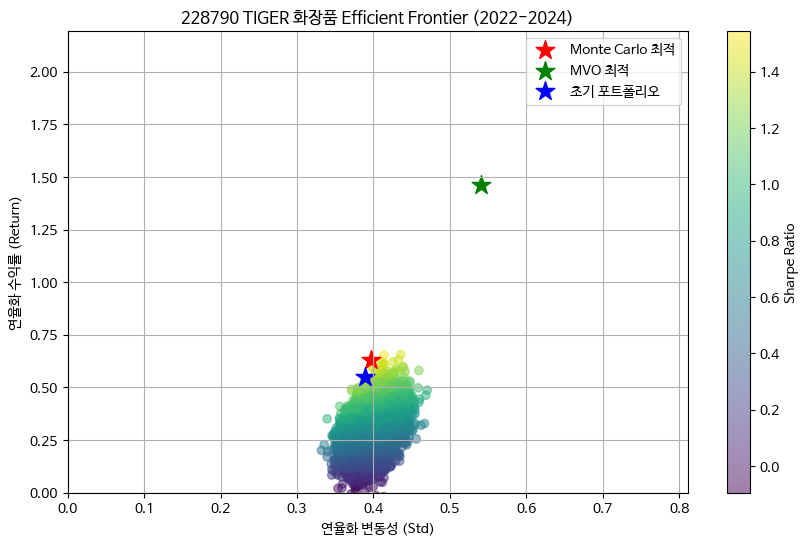


수익률 통계:
           214450      051900      257720      161890      278470      090430  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     0.005784    0.000158    0.007968    0.001394   -0.000241   -0.000143   
std      0.036657    0.024208    0.058343    0.031728    0.043102    0.034212   
min     -0.105407   -0.080624   -0.226027   -0.110938   -0.122592   -0.249095   
25%     -0.018358   -0.012587   -0.025130   -0.018018   -0.027125   -0.015139   
50%      0.002240   -0.001387    0.005441   -0.002281    0.000000   -0.000817   
75%      0.025068    0.013139    0.036415    0.018832    0.023305    0.013855   
max      0.149449    0.073684    0.299505    0.108696    0.138889    0.090449   

           192820      018290      002790      241710      352480      114840  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     0.002253    0.005615   -0.000953    0.002680   -0.000888    0.001317   
std      0.035500 

In [39]:
from scipy.optimize import minimize

# 설정
etf_ticker = "228790"  # TIGER 화장품
risk_free_rate = 0.02  # 무위험 수익률
date = "20241010"  # 포트폴리오 데이터 기준 날짜

# 1. ETF 구성 종목과 비중 가져오기
portfolio = stock.get_etf_portfolio_deposit_file(etf_ticker, date)
valid_portfolio = portfolio[portfolio.index.str.match(r"^\d{6}$") & (portfolio["비중"] > 0)].copy()
initial_tickers = valid_portfolio.index.tolist()
initial_weights = valid_portfolio["비중"].values / 100

# 2. 종가 데이터 가져오기
price_data = {}
for ticker in initial_tickers:
    try:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
        if not df.empty and "종가" in df.columns:
            price_data[ticker] = df["종가"]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

prices = pd.DataFrame(price_data).dropna()
tickers = prices.columns.tolist()
valid_indices = [initial_tickers.index(ticker) for ticker in tickers if ticker in initial_tickers]
initial_weights = initial_weights[valid_indices]
initial_weights /= initial_weights.sum()

# 3. 일별 수익률 계산
returns = prices.pct_change().dropna()

# 4. 포트폴리오 성과 계산 함수
def portfolio_performance(weights, returns, risk_free_rate):
    portfolio_returns = returns.dot(weights)
    mean_return = portfolio_returns.mean() * 252
    portfolio_std = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / portfolio_std
    return mean_return, portfolio_std, sharpe_ratio, portfolio_returns

# 5. Monte Carlo 시뮬레이션
num_portfolios = 10000
results_mc = np.zeros((3, num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= weights.sum()
    weights_record.append(weights)
    mean_return, std, sharpe, _ = portfolio_performance(weights, returns, risk_free_rate)
    results_mc[0, i] = mean_return
    results_mc[1, i] = std
    results_mc[2, i] = sharpe

max_sharpe_idx_mc = results_mc[2].argmax()
optimal_weights_mc = weights_record[max_sharpe_idx_mc]
mc_return, mc_std, mc_sharpe, mc_returns = portfolio_performance(optimal_weights_mc, returns, risk_free_rate)

# 6. MVO (Mean-Variance Optimization)
def neg_sharpe_ratio(weights, returns, risk_free_rate):
    mean_return, std, _, _ = portfolio_performance(weights, returns, risk_free_rate)
    return -((mean_return - risk_free_rate) / std)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 0.3) for _ in range(len(tickers)))  # 상한 30%로 조정
result = minimize(neg_sharpe_ratio, initial_weights, args=(returns, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_mvo = result.x
mvo_return, mvo_std, mvo_sharpe, mvo_returns = portfolio_performance(optimal_weights_mvo, returns, risk_free_rate)

# 7. VaR 계산
def calculate_var(portfolio_returns, confidence_level=0.95):
    return np.percentile(portfolio_returns, (1 - confidence_level) * 100) * 252

var_95_mc = calculate_var(mc_returns)
var_95_mvo = calculate_var(mvo_returns)

# 8. 초기 포트폴리오 성과
initial_return, initial_std, initial_sharpe, initial_returns = portfolio_performance(initial_weights, returns, risk_free_rate)
var_95_initial = calculate_var(initial_returns)

# 9. 결과 출력
print(f"\n{etf_ticker} TIGER 화장품 - Monte Carlo 최적 비중:")
for ticker, weight in zip(tickers, optimal_weights_mc):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")
print(f"MC 연율화 수익률: {mc_return:.4f}, 변동성: {mc_std:.4f}, 샤프: {mc_sharpe:.4f}, 95% VaR: {var_95_mc:.4f}")

print(f"\n{etf_ticker} TIGER 화장품 - MVO 최적 비중:")
for ticker, weight in zip(tickers, optimal_weights_mvo):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")
print(f"MVO 연율화 수익률: {mvo_return:.4f}, 변동성: {mvo_std:.4f}, 샤프: {mvo_sharpe:.4f}, 95% VaR: {var_95_mvo:.4f}")

print(f"\n초기 포트폴리오 성과:")
print(f"연율화 수익률: {initial_return:.4f}, 변동성: {initial_std:.4f}, 샤프: {initial_sharpe:.4f}, 95% VaR: {var_95_initial:.4f}")

# 10. Efficient Frontier 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results_mc[1, :], results_mc[0, :], c=results_mc[2, :], cmap="viridis", marker="o", alpha=0.5)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(mc_std, mc_return, marker="*", color="r", s=200, label="Monte Carlo 최적")
plt.scatter(mvo_std, mvo_return, marker="*", color="g", s=200, label="MVO 최적")
plt.scatter(initial_std, initial_return, marker="*", color="b", s=200, label="초기 포트폴리오")
plt.xlim(0, max(max(results_mc[1, :]), mvo_std) * 1.5)
plt.ylim(0, max(max(results_mc[0, :]), mvo_return) * 1.5)
plt.title(f"{etf_ticker} TIGER 화장품 Efficient Frontier (2022-2024)")
plt.xlabel("연율화 변동성 (Std)")
plt.ylabel("연율화 수익률 (Return)")
plt.legend()
plt.grid(True)
plt.show()

# 데이터 점검
print("\n수익률 통계:")
print(returns.describe())
print("\n수익률 이상치 확인 (3표준편차 초과):")
print(returns[(returns > returns.mean() + 3 * returns.std()) | (returns < returns.mean() - 3 * returns.std())])